In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import os
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

/home/vt337/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
proj_dir = Path("..") / "Data/r77-mini-data-fortnight"
print(proj_dir.joinpath("input"))

data_dir = proj_dir
input_dir = data_dir.joinpath("input")
fixed_input_dir = input_dir.joinpath("fixed")
temporal_input_dir = input_dir.joinpath("temporal")
target_dir = data_dir.joinpath("target")
fixed_target_dir = target_dir.joinpath("fixed")
temporal_target_dir = target_dir.joinpath("temporal")

../Data/r77-mini-data-fortnight/input


In [3]:
files = list(temporal_target_dir.iterdir())

index_dir = Path("..")/"Index"
files_index = list(index_dir.iterdir())
indices = np.load(files_index[0]).squeeze()

#First hour of data
index = indices[0]
tt = np.load(files[index]).squeeze()
tt.shape

(144, 70, 100, 3)

In [4]:
transposed_tt = np.transpose(tt, (0, 2, 3, 1))[:,:,:,:64]

reshaped_tt = transposed_tt.reshape(-1, 3, 64)

reshaped_tt.shape

(14400, 3, 64)

In [5]:
files_fixed = list(fixed_input_dir.iterdir())
#First hour of data
index = indices[0]
fi = np.load(files_fixed[index]).squeeze()
fi.shape

(144, 2)

In [6]:
files_ft = list(fixed_target_dir.iterdir())
#First hour of data
index = indices[0]
ft = np.load(files_ft[index]).squeeze()
ft.shape

(144, 100, 2)

In [7]:
stdev_orog = np.array([np.std(i) for i in ft]).reshape(-1,1)
stdev_orog.shape

(144, 1)

In [8]:
fixed_input = np.hstack((fi, stdev_orog))
fixed_input.shape

(144, 3)

In [9]:
reshaped_fi = np.repeat(fi, 100, axis=0)
reshaped_fi.shape

(14400, 2)

In [10]:
lsf = fixed_input[:,0]
orog = fixed_input[:,1]

In [11]:
class_1 = fixed_input[(lsf == 0)]
class_2 = fixed_input[(lsf == 1)]
class_3 = fixed_input[(lsf < 1) & (lsf > 0)]
#class_3 = reshaped_fi[(lsf < ) & (orog > 0.5)]
#class_4 = reshaped_fi[(lsf > 0.5) & (orog > 0.5)]

In [12]:
print(f'Class 1 shape: {class_1.shape}')
print(f'Class 2 shape: {class_2.shape}')
print(f'Class 3 shape: {class_3.shape}')
#print(f'Class 4 shape: {class_4.shape}')

Class 1 shape: (49, 3)
Class 2 shape: (22, 3)
Class 3 shape: (73, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

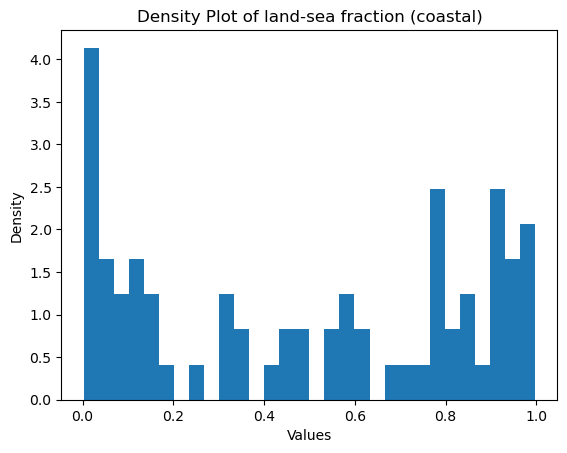

In [13]:
plt.hist(class_3[:,0], bins = 30, density = True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Plot of land-sea fraction (coastal)')

plt.show

Text(0.5, 1.0, 'Density Plot of Std dev Orography (Coastal)')

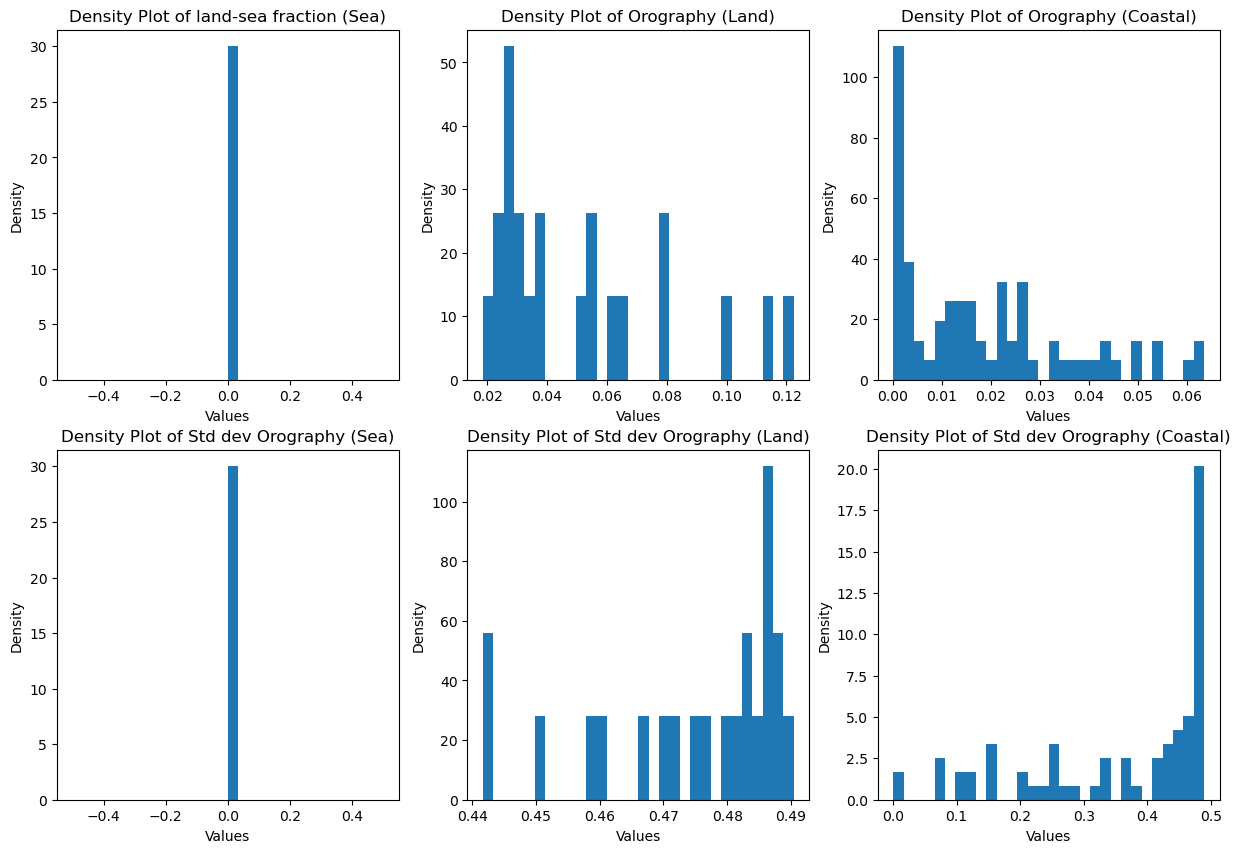

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].hist(class_1[:,1], bins=30, density=True)
axs[0,0].set_xlabel('Values')
axs[0,0].set_ylabel('Density')
axs[0,0].set_title('Density Plot of land-sea fraction (Sea)')

axs[0,1].hist(class_2[:,1], bins=30, density=True)
axs[0,1].set_xlabel('Values')
axs[0,1].set_ylabel('Density')
axs[0,1].set_title('Density Plot of Orography (Land)')

axs[0,2].hist(class_3[:,1], bins=30, density=True)
axs[0,2].set_xlabel('Values')
axs[0,2].set_ylabel('Density')
axs[0,2].set_title('Density Plot of Orography (Coastal)')

axs[1,0].hist(class_1[:,2], bins=30, density=True)
axs[1,0].set_xlabel('Values')
axs[1,0].set_ylabel('Density')
axs[1,0].set_title('Density Plot of Std dev Orography (Sea)')

axs[1,1].hist(class_2[:,2], bins=30, density=True)
axs[1,1].set_xlabel('Values')
axs[1,1].set_ylabel('Density')
axs[1,1].set_title('Density Plot of Std dev Orography (Land)')

axs[1,2].hist(class_3[:,2], bins=30, density=True)
axs[1,2].set_xlabel('Values')
axs[1,2].set_ylabel('Density')
axs[1,2].set_title('Density Plot of Std dev Orography (Coastal)')


In [15]:
reshaped_fi = np.repeat(fixed_input, 100, axis=0)

In [16]:
lsf = reshaped_fi[:,0]
orog = reshaped_fi[:,1]
stdev_orog = reshaped_fi[:,2]

In [17]:
class_1 = reshaped_fi[(lsf == 0)]
class_2 = reshaped_fi[(lsf == 1) & (orog < 0.06)]
class_3 = reshaped_fi[(lsf == 1) & (orog > 0.06)]
class_4 = reshaped_fi[(lsf < 1) & (lsf > 0) & (orog < 0.03)]
class_5 = reshaped_fi[(lsf < 1) & (lsf > 0) & (orog > 0.03)]

In [18]:
print(f'Class 1 shape: {class_1.shape}')
print(f'Class 2 shape: {class_2.shape}')
print(f'Class 3 shape: {class_3.shape}')
print(f'Class 4 shape: {class_4.shape}')
print(f'Class 4 shape: {class_5.shape}')

Class 1 shape: (4900, 3)
Class 2 shape: (1500, 3)
Class 3 shape: (700, 3)
Class 4 shape: (5700, 3)
Class 4 shape: (1600, 3)


In [19]:
indices1 = np.where((lsf == 0))[0]
trainingdata1 = reshaped_tt[indices1]

indices2 = np.where((lsf == 1) & (orog <= 0.06))[0]
trainingdata2 = reshaped_tt[indices2]

indices3 = np.where((lsf == 1) & (orog > 0.06))[0]
trainingdata3 = reshaped_tt[indices3]

indices4 = np.where((lsf < 1) & (lsf > 0) & (orog <= 0.03))[0]
trainingdata4 = reshaped_tt[indices4]

indices5 = np.where((lsf < 1) & (lsf > 0) & (orog > 0.03))[0]
trainingdata5 = reshaped_tt[indices5]

In [20]:
print(f'class1 training data {trainingdata1.shape}')
print(f'class2 training data {trainingdata2.shape}')
print(f'class3 training data {trainingdata3.shape}')
print(f'class4 training data {trainingdata4.shape}')
print(f'class5 training data {trainingdata5.shape}')


class1 training data (4900, 3, 64)
class2 training data (1500, 3, 64)
class3 training data (700, 3, 64)
class4 training data (5700, 3, 64)
class5 training data (1600, 3, 64)


In [21]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [22]:

data_list = [trainingdata1, trainingdata2, trainingdata3,trainingdata4,trainingdata5]


In [23]:


for idx, trainingdata in enumerate(data_list, start = 1): 
    
    

    model = Unet1D(
        dim = 64,
        dim_mults = (1, 2, 4, 8),
        channels = 3
    ).to(device)

    diffusion = GaussianDiffusion1D(
        model,
        seq_length = 64,
        timesteps = 100,
        objective = 'pred_v'
    ).to(device)

    training_seq =  torch.from_numpy(trainingdata) # features are normalized from 0 to 1


    trainer = Trainer1D(
        diffusion,
        dataset = training_seq,
        train_batch_size = 10, #set batch size here (take 100 samples, one grid)
        train_lr = 1e-4,
        train_num_steps = 10000,         # total training steps (1000)
        gradient_accumulate_every = 2,    # gradient accumulation steps
        ema_decay = 0.995,                # exponential moving average decay
        amp = True,                       # turn on mixed precision
    )
    trainer.train()

    # after a lot of training

    sampled_seq = diffusion.sample(batch_size = 100).to(device)
    torch.save(sampled_seq, f"sampled_seq{idx}.pt") 

/home/vt337/.local/lib/python3.10/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
loss: 0.0089: 100%|██████████| 10000/10000 [10:13<00:00, 16.29it/s]


training complete


loss: 0.0017: 100%|██████████| 10000/10000 [10:50<00:00, 15.37it/s]


training complete


loss: 0.0024: 100%|██████████| 10000/10000 [12:06<00:00, 13.76it/s]


training complete


loss: 0.0063: 100%|██████████| 10000/10000 [10:09<00:00, 16.40it/s]


training complete


loss: 0.0081: 100%|██████████| 10000/10000 [10:58<00:00, 15.18it/s]


training complete


sampling loop time step: 100%|██████████| 100/100 [00:00<00:00, 126.59it/s]


In [24]:
sampled_sequences_list = []

for i in range(1, 6):  
    sampled_seq = torch.load(f"sampled_seq{i}.pt")
    sampled_sequences_list.append(sampled_seq.cpu().numpy())

sampled_sequences = np.array(sampled_sequences_list)


In [25]:
folder = 'Samples_cond_1'
if not os.path.exists(folder):
    os.makedirs(folder)

file_path = os.path.join(folder, 'sample.npy')
np.save(file_path, sampled_sequences)

In [26]:
class_1 = reshaped_fi[(lsf == 0)]
class_2 = reshaped_fi[(lsf == 1)]
class_3 = reshaped_fi[(lsf < 1) & (lsf > 0) & (stdev_orog <= 0.2)]
class_4 = reshaped_fi[(lsf < 1) & (lsf > 0) & (stdev_orog > 0.2) & (stdev_orog <= 0.4)]
class_5 = reshaped_fi[(lsf < 1) & (lsf > 0) & (stdev_orog > 0.4)]

In [27]:
print(f'Class 1 shape: {class_1.shape}')
print(f'Class 2 shape: {class_2.shape}')
print(f'Class 3 shape: {class_3.shape}')
print(f'Class 4 shape: {class_4.shape}')
print(f'Class 4 shape: {class_5.shape}')

Class 1 shape: (4900, 3)
Class 2 shape: (2200, 3)
Class 3 shape: (1400, 3)
Class 4 shape: (1700, 3)
Class 4 shape: (4200, 3)


In [28]:
indices1 = np.where((lsf == 0))[0]
trainingdata1 = reshaped_tt[indices1]

indices2 = np.where((lsf == 1))[0]
trainingdata2 = reshaped_tt[indices2]

indices3 = np.where((lsf < 1) & (lsf > 0) & (stdev_orog <= 0.2))[0]
trainingdata3 = reshaped_tt[indices3]

indices4 = np.where((lsf < 1) & (lsf > 0) & (stdev_orog > 0.2) & (stdev_orog <= 0.4))[0]
trainingdata4 = reshaped_tt[indices4]

indices5 = np.where((lsf < 1) & (lsf > 0) & (stdev_orog > 0.4))[0]
trainingdata5 = reshaped_tt[indices5]

In [29]:
print(f'class1 training data {trainingdata1.shape}')
print(f'class2 training data {trainingdata2.shape}')
print(f'class3 training data {trainingdata3.shape}')
print(f'class4 training data {trainingdata4.shape}')
print(f'class5 training data {trainingdata5.shape}')

class1 training data (4900, 3, 64)
class2 training data (2200, 3, 64)
class3 training data (1400, 3, 64)
class4 training data (1700, 3, 64)
class5 training data (4200, 3, 64)


In [30]:
data_list = [trainingdata1, trainingdata2, trainingdata3,trainingdata4,trainingdata5]

In [31]:


for idx, trainingdata in enumerate(data_list, start = 1): 
    
    

    model = Unet1D(
        dim = 64,
        dim_mults = (1, 2, 4, 8),
        channels = 3
    ).to(device)

    diffusion = GaussianDiffusion1D(
        model,
        seq_length = 64,
        timesteps = 100,
        objective = 'pred_v'
    ).to(device)


    training_seq =  torch.from_numpy(trainingdata)  

    trainer = Trainer1D(
        diffusion,
        dataset = training_seq,
        train_batch_size = 10, #set batch size here (take 100 samples, one grid)
        train_lr = 1e-4,
        train_num_steps = 10000,         # total training steps (1000)
        gradient_accumulate_every = 2,    # gradient accumulation steps
        ema_decay = 0.995,                # exponential moving average decay
        amp = True,                       # turn on mixed precision
    )
    trainer.train()

    # after a lot of training

    sampled_seq = diffusion.sample(batch_size = 100).to(device)
    torch.save(sampled_seq, f"sampled_seq{idx}.pt") 

  0%|          | 0/10000 [00:00<?, ?it/s]

loss: 0.0032:  76%|███████▌  | 7594/10000 [07:45<02:18, 17.36it/s]Exception ignored in: <function _releaseLock at 0x7f2cd01f13f0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
loss: 0.0037:  78%|███████▊  | 7800/10000 [07:58<02:07, 17.23it/s]

In [ ]:
sampled_sequences_list = []

for i in range(1, 6):  
    sampled_seq = torch.load(f"sampled_seq{i}.pt")
    sampled_sequences_list.append(sampled_seq.cpu().numpy())

sampled_sequences = np.array(sampled_sequences_list)


In [ ]:
folder = 'Samples_cond_4'
if not os.path.exists(folder):
    os.makedirs(folder)

file_path = os.path.join(folder, 'sample.npy')
np.save(file_path, sampled_sequences)